In [108]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [109]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21


In [110]:
# Calculate levels of support from the last 

In [111]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,300.0,0.000609


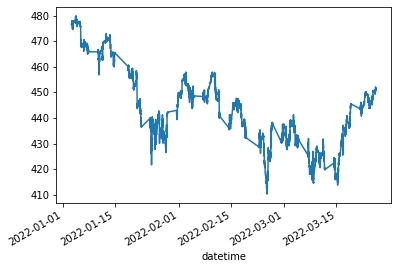

In [112]:
df.set_index('datetime')['close'].plot()

In [113]:
df['diff'] = df['datetime'].diff().dt.seconds
df['diff'].value_counts().sort_index()

300.0      10856
600.0         49
900.0          1
1200.0         1
25500.0        1
29100.0       56
Name: diff, dtype: int64

In [159]:
time_since_opening_array = [0]

time_since_opening = 1.0
for n,x in enumerate(df['diff'].values.tolist()[1:]):
    
    time_since_opening+=x
    
    if x>20000:
        time_since_opening = 1.0
        
    time_since_opening_array.append(time_since_opening)
    
df['time_since_opening'] = time_since_opening_array

In [286]:
df['close_13_ma'] = df['close'].rolling(13,min_periods=1).mean()
df['close_48_ma'] = df['close'].rolling(48,min_periods=1).mean()
df['close_13_48_diff'] = df['close_48_ma'] - df['close_13_ma']

In [311]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low','close_13_ma','close_48_ma']].fillna(0.1).values
    lookback_data = lookback_data/(lookback_data[-1])
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    
    X.append(lookback_data)
    y.append(outcome_data)
    
    t+=1

10965 ticks found


In [312]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [313]:
X = np.stack(X)
X.shape

(10939, 21, 7)

In [314]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

# Defining a simple CNN

In [315]:
import tensorflow as tf
from tensorflow import keras

In [316]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [317]:
model = keras.Sequential([
    keras.layers.Conv1D(24,2,
                        activation='relu',
                        input_shape=(X_train.shape[1],X_train.shape[2]),
                        kernel_regularizer=tf.keras.regularizers.l2(l=.1)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    #keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [318]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [319]:
callbacks = [keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)]

In [325]:
'''
Original Results

Train on 6000 samples, validate on 4939 samples
Epoch 1/5
6000/6000 - 1s - loss: 0.1275 - auc: 0.7448 - val_loss: 0.1622 - val_auc: 0.6355
Epoch 2/5
6000/6000 - 1s - loss: 0.1274 - auc: 0.7465 - val_loss: 0.1593 - val_auc: 0.6444
Epoch 3/5
6000/6000 - 1s - loss: 0.1285 - auc: 0.7369 - val_loss: 0.1640 - val_auc: 0.6266
Epoch 4/5
6000/6000 - 1s - loss: 0.1278 - auc: 0.7370 - val_loss: 0.1620 - val_auc: 0.6323
Epoch 5/5
6000/6000 - 1s - loss: 0.1274 - auc: 0.7484 - val_loss: 0.1628 - val_auc: 0.6260
'''

history = model.fit(X_train,y_train,batch_size=100,epochs=100,verbose=2,validation_data=(X_test,y_test))

Train on 6000 samples, validate on 4939 samples
Epoch 1/100
6000/6000 - 1s - loss: 0.1317 - auc: 0.7040 - val_loss: 0.1603 - val_auc: 0.6427
Epoch 2/100
6000/6000 - 1s - loss: 0.1310 - auc: 0.7153 - val_loss: 0.1585 - val_auc: 0.6425
Epoch 3/100
6000/6000 - 1s - loss: 0.1316 - auc: 0.7136 - val_loss: 0.1596 - val_auc: 0.6395
Epoch 4/100
6000/6000 - 1s - loss: 0.1310 - auc: 0.7156 - val_loss: 0.1583 - val_auc: 0.6419
Epoch 5/100
6000/6000 - 1s - loss: 0.1308 - auc: 0.7159 - val_loss: 0.1603 - val_auc: 0.6420
Epoch 6/100
6000/6000 - 1s - loss: 0.1304 - auc: 0.7201 - val_loss: 0.1591 - val_auc: 0.6388
Epoch 7/100
6000/6000 - 1s - loss: 0.1303 - auc: 0.7239 - val_loss: 0.1590 - val_auc: 0.6411
Epoch 8/100
6000/6000 - 1s - loss: 0.1308 - auc: 0.7098 - val_loss: 0.1586 - val_auc: 0.6416
Epoch 9/100
6000/6000 - 1s - loss: 0.1309 - auc: 0.7062 - val_loss: 0.1588 - val_auc: 0.6376
Epoch 10/100
6000/6000 - 1s - loss: 0.1310 - auc: 0.7161 - val_loss: 0.1591 - val_auc: 0.6456
Epoch 11/100
6000/600

Epoch 88/100
6000/6000 - 1s - loss: 0.1285 - auc: 0.7241 - val_loss: 0.1618 - val_auc: 0.6327
Epoch 89/100
6000/6000 - 1s - loss: 0.1287 - auc: 0.7285 - val_loss: 0.1595 - val_auc: 0.6399
Epoch 90/100
6000/6000 - 1s - loss: 0.1290 - auc: 0.7213 - val_loss: 0.1588 - val_auc: 0.6341
Epoch 91/100
6000/6000 - 1s - loss: 0.1284 - auc: 0.7248 - val_loss: 0.1576 - val_auc: 0.6403
Epoch 92/100
6000/6000 - 1s - loss: 0.1283 - auc: 0.7237 - val_loss: 0.1615 - val_auc: 0.6335
Epoch 93/100
6000/6000 - 1s - loss: 0.1294 - auc: 0.7144 - val_loss: 0.1601 - val_auc: 0.6381
Epoch 94/100
6000/6000 - 1s - loss: 0.1281 - auc: 0.7260 - val_loss: 0.1626 - val_auc: 0.6342
Epoch 95/100
6000/6000 - 1s - loss: 0.1287 - auc: 0.7223 - val_loss: 0.1577 - val_auc: 0.6387
Epoch 96/100
6000/6000 - 1s - loss: 0.1293 - auc: 0.7173 - val_loss: 0.1586 - val_auc: 0.6359
Epoch 97/100
6000/6000 - 1s - loss: 0.1289 - auc: 0.7203 - val_loss: 0.1578 - val_auc: 0.6386
Epoch 98/100
6000/6000 - 1s - loss: 0.1284 - auc: 0.7183 - v

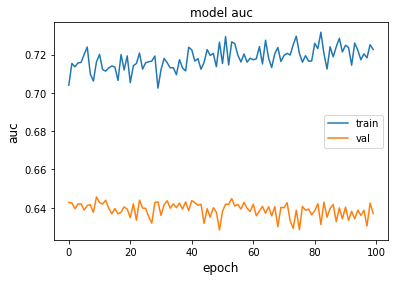

In [327]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [328]:
test_pred = model.predict(X_test).ravel()
train_pred = model.predict(X_train).ravel()

In [329]:
df['model_prediction'] = np.concatenate([np.zeros(22),train_pred,test_pred,np.zeros(4)],axis=0)

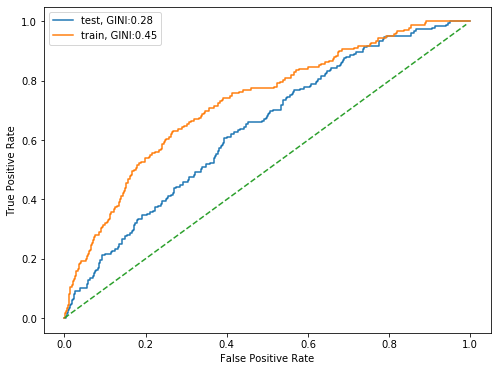

In [330]:
from sklearn.metrics import roc_curve, roc_auc_score
fig,axes = plt.subplots(1,1,figsize=[8,6])
fpr,tpr,_ = roc_curve(y_test,model.predict(X_test))

score = 2*roc_auc_score(y_test,model.predict(X_test))-1
axes.plot(fpr,tpr,label=f'test, GINI:{score:0.2f}')

fpr,tpr,_ = roc_curve(y_train,model.predict(X_train))
score = 2*roc_auc_score(y_train,model.predict(X_train))-1
axes.plot(fpr,tpr,label=f'train, GINI:{score:0.2f}')

axes.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),ls='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

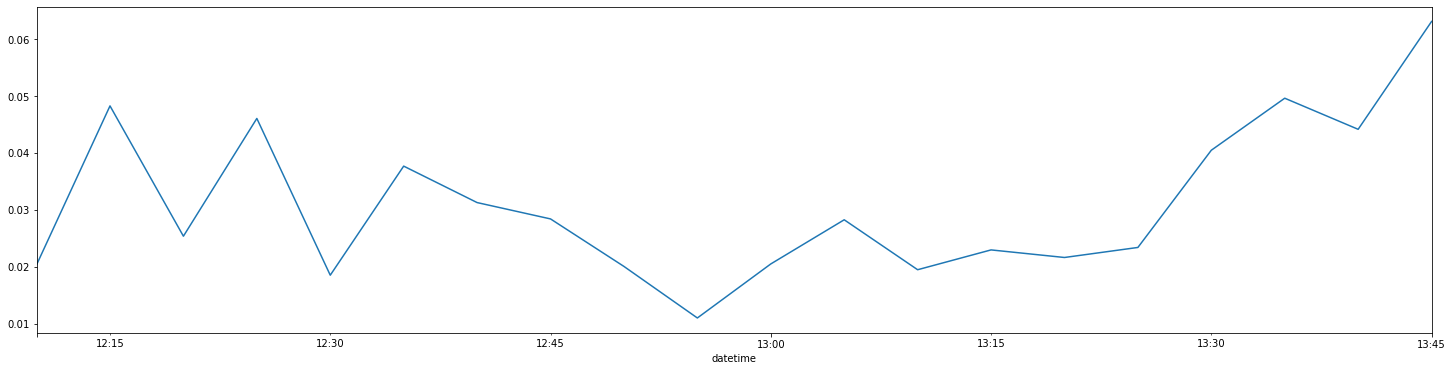

In [331]:
fig,axes = plt.subplots(1,1,figsize=[25,6])
df.set_index('datetime')['model_prediction'][-25:-5].plot(ax=axes)
#plt.yscale('log')

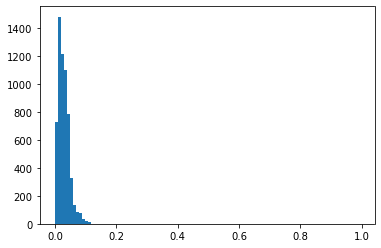

In [333]:
plt.hist(model.predict(X_train),bins=100)
plt.show()